In [ ]:
# Importing functions and classes we'll use

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
from tqdm import tqdm
import keras
import sys
import scipy.stats
import json
import numpy.fft
import time
from decimal import Decimal
import math
import seaborn as sns
%matplotlib inline

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
df = pd.read_excel('/content/sample_data/new_dataset.xlsx')
node1_delay = df[['node1_delay']]

dataset = node1_delay.values

# MA Filter Implementation

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real

        # Find autocorrelation peaks
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))

def moving_average(data, _range):
    ret = np.cumsum(data)
    ret[_range:] = ret[int(_range):] - ret[:-int(_range)]
    return ret[int(_range) - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, int(_range))[::int(slide)]
    return list(ret)

def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Algorithm to transfer data in tabular format

In [ ]:
def create_multistep_dataset(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# ESN Model Library

In [ ]:
def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

# Function to evaluate multi-step forecasting models

In [ ]:
from sklearn.metrics import mean_squared_error

def eval_model(Y_true, Y_pred):
    scores = []

    # Calculate scores for each value on the horizon
    # For each of the col in Y_true we have corresponding y_pred
    for i in range(Y_true.shape[1]):
        mse = mean_squared_error(Y_true[:, i], Y_pred[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)

    # Calculate score for the whole prediction
    total_score = 0
    for row in range(Y_true.shape[0]):
        for col in range(Y_true.shape[1]):
            total_score += (Y_true[row, col] - Y_pred[row, col]) ** 2

    total_score = np.sqrt(total_score / (Y_true.shape[0] * Y_true.shape[1]))
    return total_score, scores

In [ ]:
def evaluate_multistep_forecast(predictions, actual):
    # Calculate RMSE and MAE for each prediction
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)

    return rmse, mae

# Recursive Strategy

In [ ]:
def recursive_strategy(model, X_row, n_steps):
    forecasts = []
    shape_0 = X_row.shape[0]
    shape_1 = X_row.shape[1]

    for i in range(n_steps):
        X_row = np.reshape(X_row, (shape_0, 1, shape_1))
        forecast = model.predict(X_row, verbose=0)
        X_row.reshape(X_row.shape[2],)
        forecasts.append(forecast[0, 0])
        X_row = X_row.tolist()
        X_row[0][0].append(forecast[0, 0])
        X_row = X_row[0][0][1:]
        X_row = np.array(X_row)
    return forecasts

def make_predictions(model, X, n_steps):
    predictions = []
    for i in tqdm(range(len(X)), desc="Progress"):
      row_forecasts = recursive_strategy(model, X[i, :], n_steps)
      predictions.append(row_forecasts)
    return predictions

## First Dataset : Node1 Delay

### GRU Model

In [ ]:
# Best Params
look_back = 300 #200
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

horizons = [2, 4, 6, 8, 10]

for horizon in horizons:
    print(f"=================== horizon = {horizon}======================")
    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    testPredict = make_predictions(model, testX, horizon)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    testPredict = np.array(testPredict)
    _, new_testY = create_multistep_dataset(test, look_back, horizon)

    testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))
    testMAE = mean_absolute_error(new_testY, testPredict[:len(new_testY), :])

    print('GRU Test RMSE : %.5f' % (testRMSE))
    print('GRU Test MAE : %.5f' % (testMAE))
    print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


403/403 [==============================] - 10s 4ms/step - loss: 0.0030
Epoch 2/82
403/403 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 3/82
403/403 [==============================] - 2s 4ms/step - loss: 8.9216e-04
Epoch 4/82
403/403 [==============================] - 2s 6ms/step - loss: 7.7970e-04
Epoch 5/82
403/403 [==============================] - 2s 4ms/step - loss: 6.7533e-04
Epoch 6/82
403/403 [==============================] - 2s 4ms/step - loss: 6.5242e-04
Epoch 7/82
403/403 [==============================] - 2s 4ms/step - loss: 5.7517e-04
Epoch 8/82
403/403 [==============================] - 2s 4ms/step - loss: 5.7466e-04
Epoch 9/82
403/403 [==============================] - 2s 4ms/step - loss: 5.6784e-04
Epoch 10/82
403/403 [==============================] - 2s 5ms/step - loss: 5.7752e-04
Epoch 11/82
403/403 [==============================] - 2s 5ms/step - loss: 5.5579e-04
Epoch 12/82
403/403 [==============================] - 2s 4ms/step - loss: 5.5957

Progress: 100%|██████████| 1700/1700 [03:08<00:00,  9.03it/s]


GRU Test RMSE : 0.02379
GRU Test MAE : 0.01905
GRU Elapsed Time To generate Predictions : 188.29514 seconds
=================== horizon = 4======================


Progress: 100%|██████████| 1700/1700 [06:07<00:00,  4.62it/s]


GRU Test RMSE : 0.03096
GRU Test MAE : 0.02424
GRU Elapsed Time To generate Predictions : 367.97173 seconds
=================== horizon = 6======================


Progress: 100%|██████████| 1700/1700 [09:01<00:00,  3.14it/s]


GRU Test RMSE : 0.03708
GRU Test MAE : 0.02875
GRU Elapsed Time To generate Predictions : 541.41497 seconds
=================== horizon = 8======================


Progress: 100%|██████████| 1700/1700 [12:03<00:00,  2.35it/s]


GRU Test RMSE : 0.04262
GRU Test MAE : 0.03286
GRU Elapsed Time To generate Predictions : 723.98883 seconds
=================== horizon = 10======================


Progress:  45%|████▌     | 765/1700 [13:51<14:24:41, 55.49s/it]

In [ ]:
# Best Params
look_back = 300 #200
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

horizons = [10]

for horizon in horizons:
    print(f"=================== horizon = {horizon}======================")
    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    testPredict = make_predictions(model, testX, horizon)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    testPredict = np.array(testPredict)
    _, new_testY = create_multistep_dataset(test, look_back, horizon)

    testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))
    testMAE = mean_absolute_error(new_testY, testPredict[:len(new_testY), :])

    print('GRU Test RMSE : %.5f' % (testRMSE))
    print('GRU Test MAE : %.5f' % (testMAE))
    print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/82
403/403 [==============================] - 10s 4ms/step - loss: 0.0031
Epoch 2/82
403/403 [==============================] - 2s 4ms/step - loss: 0.0016
Epoch 3/82
403/403 [==============================] - 2s 6ms/step - loss: 9.9900e-04
Epoch 4/82
403/403 [==============================] - 2s 5ms/step - loss: 8.2883e-04
Epoch 5/82
403/403 [==============================] - 2s 4ms/step - loss: 7.2861e-04
Epoch 6/82
403/403 [==============================] - 2s 4ms/step - loss: 6.8040e-04
Epoch 7/82
403/403 [==============================] - 2s 4ms/step - loss: 6.2072e-04
Epoch 8/82
403/403 [==============================] - 2s 4ms/step - loss: 5.7601e-04
Epoch 9/82
403/403 [==============================] - 3s 6ms/step - loss: 5.7718e-04
Epoch 10/82
403/403 [==============================] - 2s 5ms/step - loss: 6.0282e-04
Epoch 11/82
403/403 [==============================] - 2s 4ms/step - loss: 5.6990e-04
Epoch 12/82
403/403 [==============================] - 2s 4ms/step - l

Progress: 100%|██████████| 1700/1700 [15:08<00:00,  1.87it/s]

GRU Test RMSE : 0.04436
GRU Test MAE : 0.03397
GRU Elapsed Time To generate Predictions : 908.04708 seconds


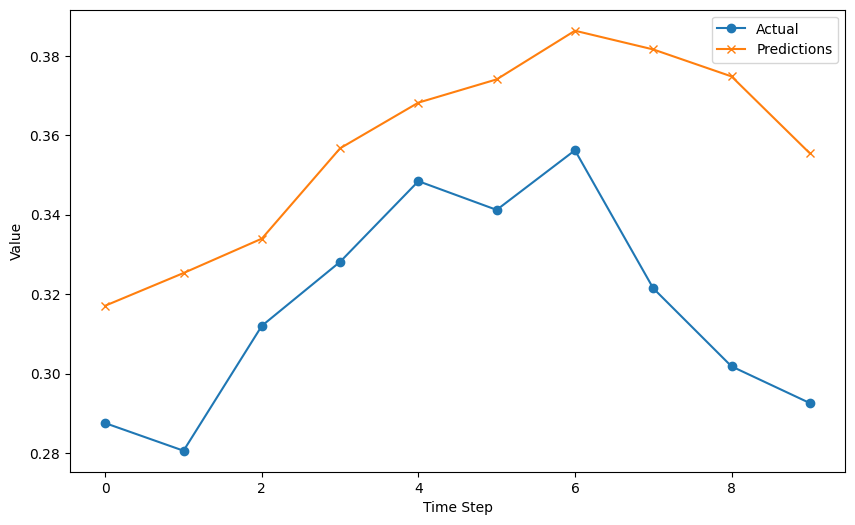

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(new_testY[1000, :], label="Actual", marker='o')
plt.plot(testPredict[1000, :], label="Predictions", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

### ESN Model

In [ ]:
# The recursive strategy for ESN Model

def recursive_strategy(model, X_row, n_steps):
    forecasts = []

    for i in range(n_steps):
        forecast = model.predict(np.array([X_row]))
        forecasts.append(forecast[0, 0])
        X_row = X_row.tolist()
        X_row.append(forecast[0, 0])
        X_row = X_row[1:]
        X_row = np.array(X_row)
    return forecasts

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time




print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

horizons = [2, 4, 6, 8, 10]

for horizon in horizons:
    print(f"=================== horizon = {horizon}======================")
    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    testPredict = make_predictions(model, testX, horizon)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    testPredict = np.array(testPredict)
    _, new_testY = create_multistep_dataset(test, look_back, horizon)

    testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))
    testMAE = mean_absolute_error(new_testY, testPredict[:len(new_testY), :])

    print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
    print('ESN Test RMSE : %.5f' % (testRMSE))
    print('ESN Test MAE : %.5f' % (testMAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.015327274933862952
ESN Model Training Elapsed Time : 1.82606 seconds
=================== horizon = 2======================


Progress: 100%|██████████| 1739/1739 [00:00<00:00, 3258.59it/s]


ESN Model Generate predictions Elapsed Time : 0.54838 seconds
ESN Test RMSE : 0.01946
ESN Test MAE : 0.01593
=================== horizon = 4======================


Progress: 100%|██████████| 1739/1739 [00:00<00:00, 1776.45it/s]


ESN Model Generate predictions Elapsed Time : 0.99124 seconds
ESN Test RMSE : 0.02519
ESN Test MAE : 0.01995
=================== horizon = 6======================


Progress: 100%|██████████| 1739/1739 [00:01<00:00, 1708.97it/s]


ESN Model Generate predictions Elapsed Time : 1.02333 seconds
ESN Test RMSE : 0.02974
ESN Test MAE : 0.02321
=================== horizon = 8======================


Progress: 100%|██████████| 1739/1739 [00:02<00:00, 656.57it/s]


ESN Model Generate predictions Elapsed Time : 2.65858 seconds
ESN Test RMSE : 0.03404
ESN Test MAE : 0.02628
=================== horizon = 10======================


Progress: 100%|██████████| 1739/1739 [00:01<00:00, 1254.88it/s]

ESN Model Generate predictions Elapsed Time : 1.39220 seconds
ESN Test RMSE : 0.03803
ESN Test MAE : 0.02919


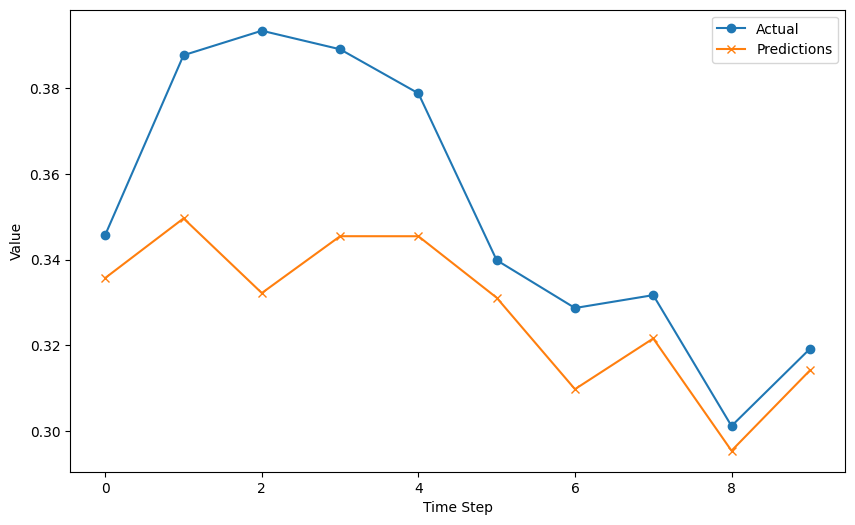

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(new_testY[5, :], label="Actual", marker='o')
plt.plot(testPredict[5, :], label="Predictions", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()